In [3]:
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git
%load_ext nvcc4jupyter

  Cloning https://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-p3iejv7e
  Running command git clone --filter=blob:none --quiet https://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-p3iejv7e
  Resolved https://github.com/andreinechaev/nvcc4jupyter.git to commit 5cd225851b7638f3f6d55a19328295f16c014079
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for nvcc4jupyter: filename=nvcc4jupyter-1.0.3-py3-none-any.whl size=7432 sha256=ad99cf1e6175f37f13398802e9e82d42885745e385f9d1c2ce678f3d359f3a95
  Stored in directory: /tmp/pip-ephem-wheel-cache-5p5p0wvp/wheels/a8/b9/18/23f8ef71ceb0f63297dd1903aedd067e6243a68ea756d6feea
Successfully built nvcc4jupyter
Source files will be saved in "/tmp/tmp6nfp8utt".


In [49]:
!nvidia-smi

Mon Jan 29 08:17:16 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
%%cuda 
#include <stdio.h>
#include <time.h>
#include <stdlib.h>
#include <curand.h>
#include <curand_kernel.h>

inline cudaError_t cudaSafeRun(cudaError_t err, const char* msg){
    if(err!=cudaSuccess){ 
        fprintf(stderr, "CUDA Runtime error at %s: %s\n", msg, cudaGetErrorString(err));
    }
    return err;
} 

__global__ void random_device(int *randArray, int size){
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    
    //random numbers
    if(idx<size){
        curandState state;
        curand_init(clock64(),idx,0,&state);
        float myrandf = curand_uniform(&state); 
        //fixing range of random numbers
        myrandf *= (1000 - 1 + 0.99999);
        myrandf += 1;
        int myrand = (int)truncf(myrandf);
        randArray[idx] = myrand;
    }
}



void random_host(int array[], int s){
    srand(time(NULL));
    for(int i=0;i<s;i++){
        array[i] = rand();
    }
}

int main() { 
    
    //1 million random elements
    int size = 1000000;
    int h_random[size];
    
    //initializing events to calculate time on host
    cudaEvent_t h_start,h_stop;
    cudaSafeRun(cudaEventCreate(&h_start),"Event Creation");
    cudaSafeRun(cudaEventCreate(&h_stop),"Event Creation");
    
    //calling host function wrapped in events
    cudaSafeRun(cudaEventRecord(h_start),"Event Recording Start");
    random_host(h_random,size);
    cudaSafeRun(cudaEventRecord(h_stop),"Event Recording Stop");
    cudaSafeRun(cudaEventSynchronize(h_stop),"Event Recording Synchronize");
    
    //calculating time
    float ht = 0;
    cudaSafeRun(cudaEventElapsedTime(&ht,h_start,h_stop),"Time Calculation");
    printf("Total time to generate random numbers on CPU: %f msecs\n", ht);
    
    //array to generate random numbers on GPU and copy back to CPU.
    int* randArray = 0;
    int* h_randArray = 0;
    
    //allocating memory
    h_randArray = (int*)malloc(size*sizeof(int));
    cudaMalloc((void**)&randArray,size*sizeof(int));
    
    //initializing events to record GPUs time
    cudaEvent_t d_start,d_stop;
    cudaSafeRun(cudaEventCreate(&d_start),"Event Creation");
    cudaSafeRun(cudaEventCreate(&d_stop),"Event Creation");
    
    //GPU random number generation wrapped in events
    cudaSafeRun(cudaEventRecord(d_start),"Event Recording Start");
    random_device<<<1000,1000>>>(randArray,size);
    cudaSafeRun(cudaDeviceSynchronize(),"Synchronization");
    cudaSafeRun(cudaEventRecord(d_stop),"Event Recording Stop");
    cudaSafeRun(cudaEventSynchronize(d_stop),"Event Synchronization");
    
    //calculating time for GPU
    float dt = 0;
    cudaSafeRun(cudaEventElapsedTime(&dt,d_start,d_stop),"Time Calculation");
    printf("Total time to generate random numbers on GPU: %f msecs\n", dt);
    
    //initializing event variables to calculate time between copying
    cudaEvent_t c_start,c_stop;
    cudaSafeRun(cudaEventCreate(&c_start),"Event Creation");
    cudaSafeRun(cudaEventCreate(&c_stop),"Event Creation");
    
    //call wrapped in event
    cudaSafeRun(cudaEventRecord(c_start),"Event Recording Start");
    cudaSafeRun(cudaMemcpy(h_randArray,randArray,size*sizeof(int),cudaMemcpyDeviceToHost),"Memory Copy");
    cudaSafeRun(cudaEventRecord(c_stop),"Event Recording Stop");
    cudaSafeRun(cudaEventSynchronize(c_stop),"Event Synchronization");
    
    //calculating time
    float ct = 0;
    cudaSafeRun(cudaEventElapsedTime(&ct,c_start,c_stop),"Time Calculation");
    printf("Total time to copy values from GPU to CPU: %f msecs\n", ct);
    
    printf("Testing first 10 random numbers\n");
    for(int i=0;i<10;i++){
        printf("%3d: %3d\n",i,h_randArray[i]);
    }
    
    cudaFree(randArray);
    free(h_randArray);

	cudaDeviceReset();
	return 0;
}

Q2:

In [17]:
%%cuda 
#include <stdio.h>
#include <time.h>
#include <stdlib.h>

inline cudaError_t cudaSafeRun(cudaError_t err, const char* msg){
    if(err!=cudaSuccess){ 
        fprintf(stderr, "CUDA Runtime error at %s: %s\n", msg, cudaGetErrorString(err));
    }
    return err;
} 

__global__ void d_sum(int* a,int* b,int* c,const int N) {
    int idx = threadIdx.x + blockDim.x * blockIdx.x;
    if(idx<N){
        c[idx] = a[idx] + b[idx];
    }
}

void h_sum(int* a,int* b,int* c,const int N){
    for(int i=0;i<N;i++){
        c[i] = a[i]+b[i];
        //printf("%3d\n",c[i]);
    }
}

int main() {
    
    //file to store values to connect data with python matplotlib
    FILE *file = fopen("time_data.txt","w");
    if(file==NULL){
        printf("Cannot open file\n");
        return;
    }
    
    //different configs
    const int N[] = {1000,10000,100000};
    const int data_size = 3;
    const int configs[] = {32,64,128,256,512,1000};
    const int config_size = 6;
    
    for (int ii=0;ii<data_size;ii++){
        
        size_t size = N[ii]*sizeof(int);
        
        //initializing variables
        int* h_a = 0;
        int* h_b = 0;
        int* h_c = 0;

        int* d_a = 0;
        int* d_b = 0;
        
        //allocating host memory
        h_a = (int*)malloc(size);
        h_b = (int*)malloc(size);
        h_c = (int*)malloc(size);

        //adding random value to compute sum
        for(int j=0;j<N[ii];j++){
            h_a[j] = j+1;
            h_b[j] = j+2;
            h_c[j] = 0;
        }

        //allocating device memory
        cudaMalloc((void**)&d_a, size);
        cudaMalloc((void**)&d_b, size);
        
        //copying data from host to device
        cudaMemcpy(d_a,h_a,size,cudaMemcpyHostToDevice);
        cudaMemcpy(d_b,h_b,size,cudaMemcpyHostToDevice);

        //initializing event variables to calculate time
        cudaEvent_t h_start,h_stop;
        cudaEventCreate(&h_start);
        cudaEventCreate(&h_stop);

        //host function call wrapped in events
        cudaEventRecord(h_start);
        h_sum(h_a,h_b,h_c,N[ii]);
        cudaEventRecord(h_stop);
        cudaEventSynchronize(h_stop);

        //time calculation
        float ht = 0;
        cudaEventElapsedTime(&ht,h_start,h_stop);
        //printf("CPU Time: %f msecs\n",ht);
        
        for (int i=0;i<config_size;i++){
            //printf("%3d,%3d\n",i,ii);
            int threadsPerBlock = configs[i];
            int blocks = ceilf(N[ii]/threadsPerBlock + 1);
            //printf("Num threads per block: %3d\n", threadsPerBlock);
            //printf("Num blocks per grid: %3d\n", blocks);

            int* d_c = 0;

            cudaMalloc((void**)&d_c, size);

            cudaEvent_t d_start,d_stop;
            cudaEventCreate(&d_start);
            cudaEventCreate(&d_stop);

            //device call wrapped in events
            cudaEventRecord(d_start);
            d_sum<<<blocks,threadsPerBlock>>>(d_a,d_b,d_c,N[ii]);
            cudaSafeRun(cudaDeviceSynchronize(),"Synchronization");
            cudaEventRecord(d_stop);
            cudaEventSynchronize(d_stop);

            float dt = 0;
            cudaEventElapsedTime(&dt,d_start,d_stop);
            //printf("GPU Time: %f msecs\n",dt);

            //copying results back to host from device
            cudaMemcpy(h_c,d_c,size,cudaMemcpyDeviceToHost);

            cudaFree(d_c);
            
            //writing to file
            fprintf(file,"%f\t%f\n",ht,dt);

            cudaDeviceReset();
        }
        //freeing device and host memory
        cudaFree(d_a);
        cudaFree(d_b);
        
        free(h_a);
        free(h_b);
        free(h_c);
    }
    fclose(file);
    return 0;
}

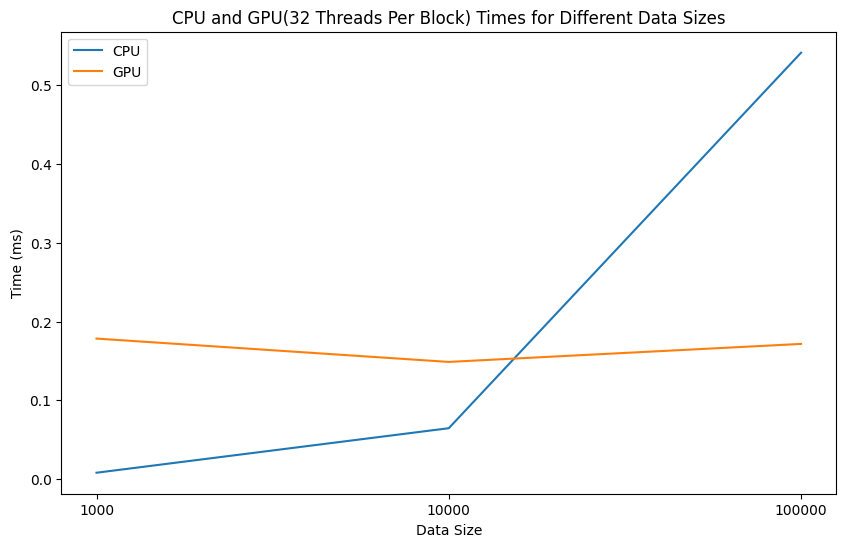

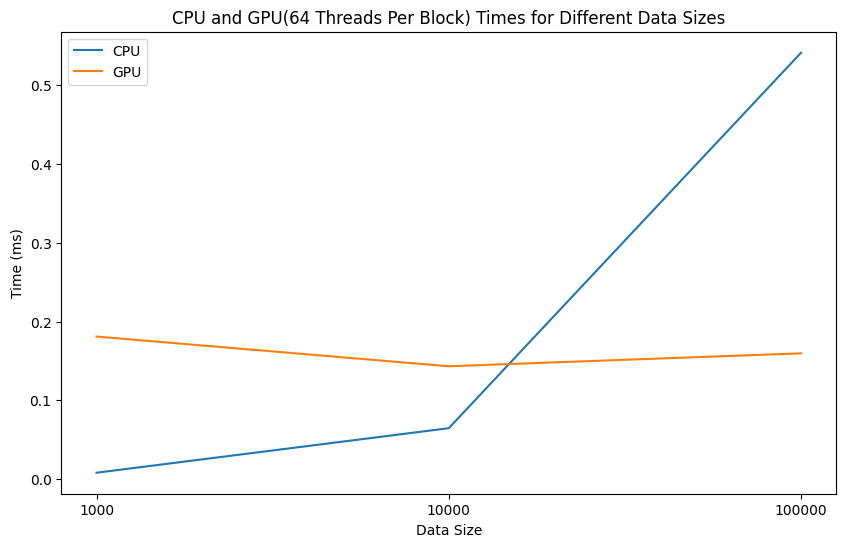

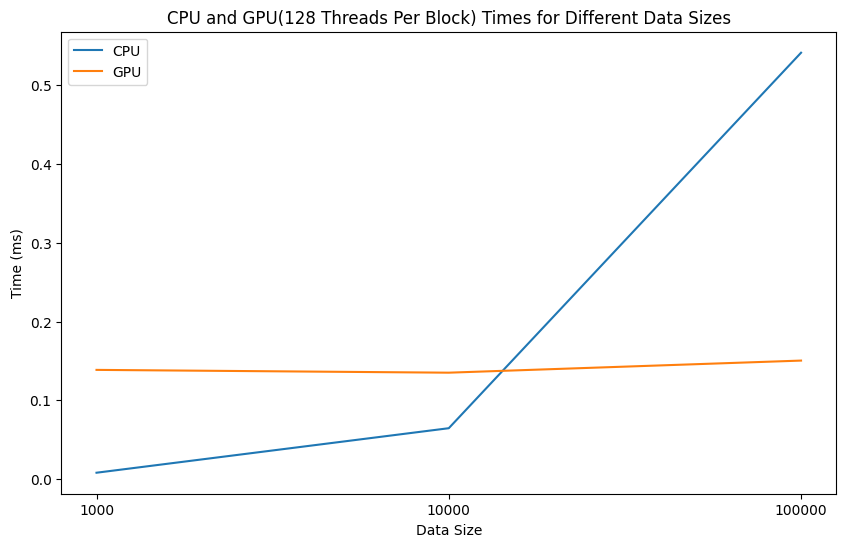

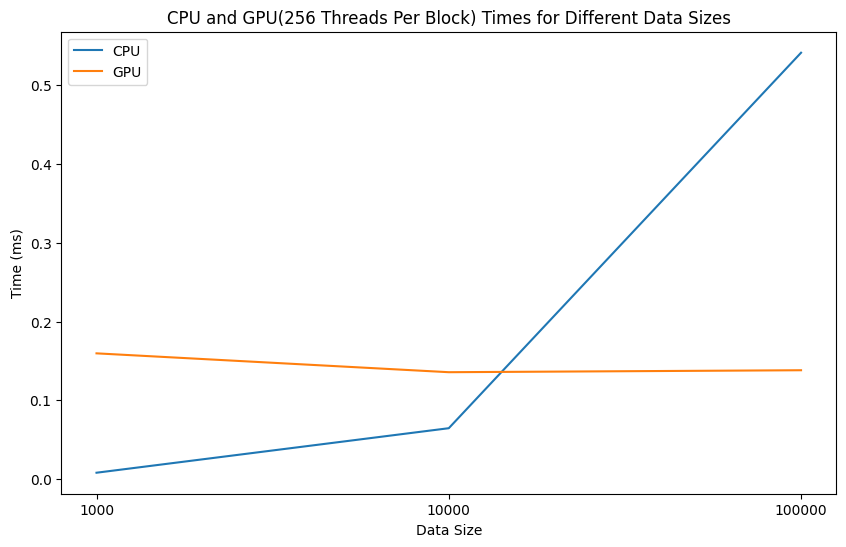

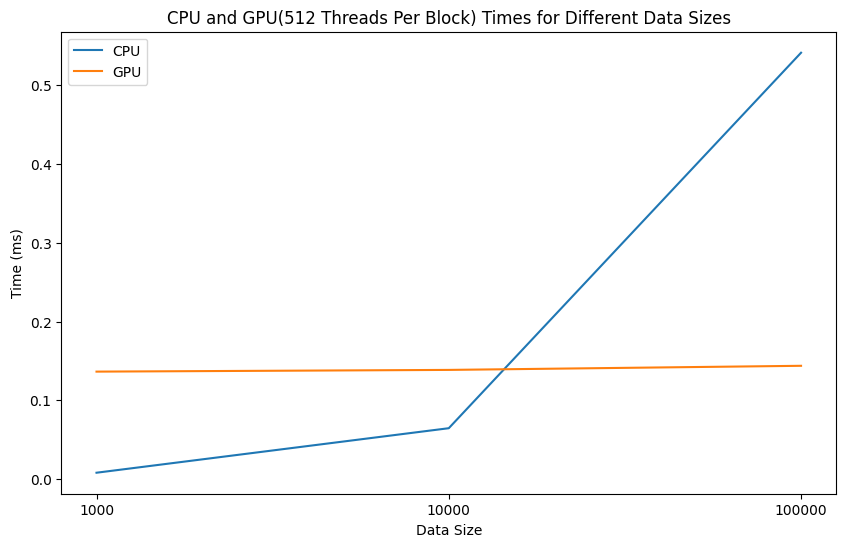

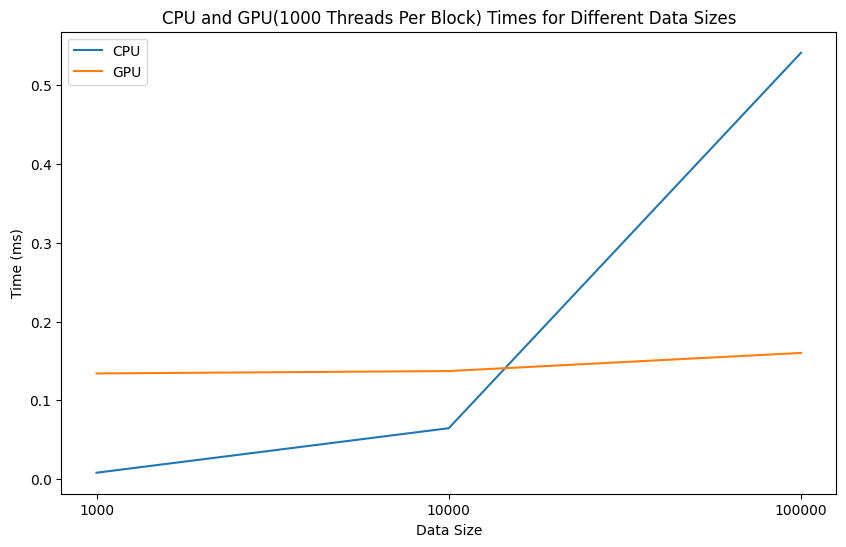

In [21]:
import matplotlib.pyplot as plt

with open('time_data.txt', 'r') as file:
    lines = file.readlines()

cpu_times = []
gpu_times = []

for line in lines:
    cpu_time, gpu_time = map(float, line.strip().split())
    cpu_times.append(cpu_time)
    gpu_times.append(gpu_time)

configs = [32,64,128,256,512,1000]
    
configurations_cpu = [cpu_times[i:i+6] for i in range(0, len(cpu_times), 6)]
configurations_gpu = [gpu_times[i:i+6] for i in range(0, len(gpu_times), 6)]
config_names = [f'{i} threads per block' for i in configs]

data_size_labels = ['1000', '10000', '100000']

config_fixed_data = [i[2] for i in configurations_cpu]

a = ['CPU','GPU']

for i in range(len(configs)):
    cpu_data = [s[i] for s in configurations_cpu]
    gpu_data = [s[i] for s in configurations_gpu]
    configurations_combined = [cpu_data,gpu_data]
    plt.figure(figsize=(10, 6))
    for item, config in enumerate(configurations_combined):
        plt.plot(config, label=a[item])

    plt.xticks(range(len(data_sizes_cpu)), data_size_labels)

    plt.xlabel('Data Size')
    plt.ylabel('Time (ms)')
    plt.title(f'CPU and GPU({configs[i]} Threads Per Block) Times for Different Data Sizes')
    plt.legend()
    plt.show()

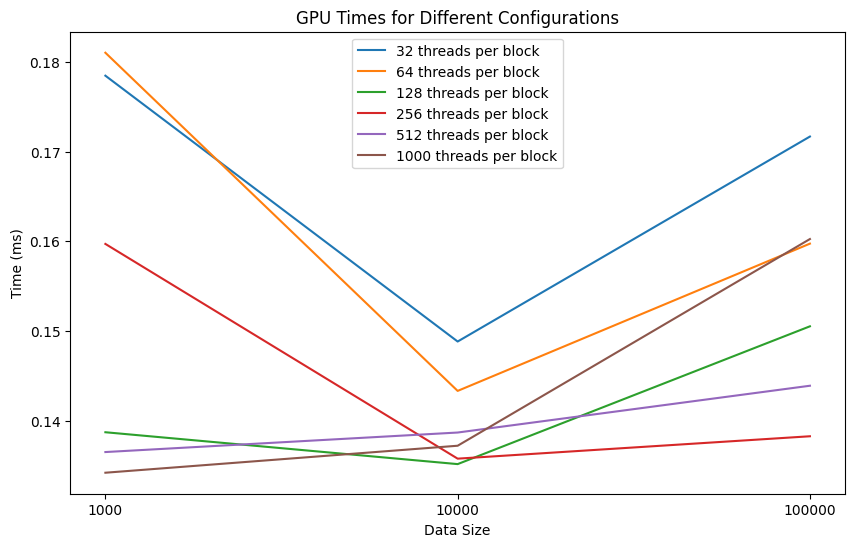

In [34]:
data_gpu = []
for k in range(6):
    x = []
    for l in range(3):
        x.append(configurations_gpu[l][k])
    data_gpu.append(x)

plt.figure(figsize=(10, 6))
for i, data_size in enumerate(data_gpu):
    plt.plot(data_size,label=config_names[i])
    
plt.xticks(range(len(data_size_labels)), data_size_labels)

plt.xlabel('Data Size')
plt.ylabel('Time (ms)')
plt.title('GPU Times for Different Configurations')
plt.legend()
plt.show()

The following references were used. Brown University's lecture slides were used to write random number function code for GPU. Dr Mobeen Movania's repository code was used for CUDA Error handling function. AI assistance was used to write code to generate plots.

References:
1. Week 11 Lecture Slides, Cuda Part 2, Brown University Computer Science, https://cs.brown.edu/courses/cs195v/lecture/week11.pdf.
2. Cuda Spring_2024 Github Repository, Mobeen Movania, https://github.com/mmmovania/CUDA_Spring_2024
3. https://chat.openai.com/share/94535829-ccfd-4735-95dc-821b5b8e55fd9

<a href="https://colab.research.google.com/github/mmmovania/CUDA_Spring2023/blob/main/Week3/CalculateSumOnGPU_BlockIdx.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>